In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5033053659206439824, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15469833088
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4061193517778319348
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [ ]:
! cp /content/drive/MyDrive/'Colab Notebooks'/dOD/tf_model/* .
! cp /content/drive/MyDrive/'Colab Notebooks'/dOD/sample/* .

In [ ]:

%load_ext autoreload
%autoreload 2
import sample_v0 as sp
from model import *
import datetime

%load_ext tensorboard

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
fps = 6
sg = sp.sample_v0('geo0', 572, 572, [92,92], fps, radius = 18)
m = mynet(input_shape=(572,572,fps),padding = 'valid',dtype='float16', drop_rate=0.2)
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-04
)
m.buildNet(optimizer=opt)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
nbatch = 20
batch_size = 7
samples = []
masks =[]
for i in range(nbatch):
    samples, masks = sg.generate(batch_size)
    xtest, ytest  = sg.generate(10)
    valid_sample=(xtest,ytest)
    #print(samples.shape)
    #print(masks.shape)
    samples = samples.astype(np.float16)
    masks = masks.astype(np.float16)
    m.net.fit(x=samples, y = masks, epochs = 1, batch_size = batch_size, validation_data= valid_sample)
    #m.net.fit(x=samples, y = masks, epochs = 1, batch_size = batch_size, validation_data= valid_sample, callbacks=[tensorboard_callback])


#%tensorboard --logdir logs

1/1 [==============================] - 1s 516ms/step - loss: 0.1022 - binary_crossentropy: nan - val_loss: 0.1022 - val_binary_crossentropy: nan


(1, 388, 388, 1)
(1, 572, 572, 6)
(1, 388, 388, 1)


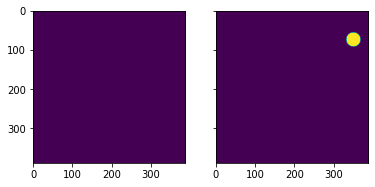

In [ ]:
import matplotlib.pyplot as plt
x, t = sg.generate(1)
y = m.predict(x)
print(t.shape)
print(x.shape)
print(y.shape)
print(m.net.layers[3].weights[1][1])
image = y[0,:,:,0].astype(np.float32)
fig,(ax1,ax2) = plt.subplots(1,2, sharey=True)
ax1.imshow(image)
ax2.imshow(t[0,:,:,0])

In [ ]:
m.net.save_weights('mymodel.h5')